In [1]:
from collections import defaultdict, Counter
from tqdm import tqdm_notebook as tqdm
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sn
import nltk
from nltk.corpus import stopwords
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
main_df = pd.read_pickle('main_df.pickle')
main_df

,id,subreddit,title,selftext,genre
0,6d8knd,talesfromtechsupport,remember your command line switches,"""hi there """,writing/stories
1,58mbft,teenmom,"""so what was matt """"addicted"""" to ? """,did he ever say what his addiction was or is h...,tv_show
2,8f73s7,Harley,no club colors,funny story i went to college in las vegas thi...,autos
3,6ti6re,ringdoorbell,not door bell but floodlight mount height,i know this is a sub for the 'ring doorbell' b...,hardware/tools
4,77sxto,intel,worried about my 8700k small fft/data stress r...,"""prime95 (regardless of version) and occt both...",electronics
...,...,...,...,...,...
1012995,5r9k4h,MSLGame,is this months rebirth and dungeon astro's wor...,i looking on what to evo3 farm next and was ex...,video_game
1012996,6529fp,CrohnsDisease,i might need a medical leave from grad school,has anyone here ever needed a medical leave fr...,health
1012997,7tiyzx,HongKong,police harassing ethnic minorities in hong kong,i thought i'd make this post so that more peop...,geo
1012998,664ha3,yorku,su eecs 2030 and eecs 2021 - need advice,hi i just finished 1st year eecs courses and h...,education


In [3]:
sampled_data = []
for genre in main_df['genre'].unique():
    genre_data = main_df[main_df['genre'] == genre].sample(n=3000, random_state=42)
    sampled_data.append(genre_data)

main_df_sampled = pd.concat(sampled_data)

# Shuffle the sampled data
main_df_sampled = main_df_sampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
main_df_sampled.to_pickle('main_df_sampled.pickle')

In [5]:
genres = sorted(main_df_sampled['genre'].unique().tolist()) # this has to be sorted to match up with lstm model

print('Number of genres:', len(genres))

Number of genres: 39


In [6]:
# Get frequencies of each subreddit using efficient pandas filtering.
frequencies = defaultdict(int)
for genre in genres:
    frequencies[genre] = len(main_df_sampled.loc[main_df_sampled['genre'] == genre])

frequencies_df = pd.DataFrame([frequencies])
frequencies_df = frequencies_df.T

print(scipy.stats.describe(list(frequencies.values())))
print(frequencies_df)

DescribeResult(nobs=39, minmax=(3000, 3000), mean=3000.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
                          0
advice/question        3000
animals                3000
anime/manga            3000
appearance             3000
arts                   3000
autos                  3000
board_game             3000
books                  3000
card_game              3000
company/website        3000
crypto                 3000
drugs                  3000
education              3000
electronics            3000
finance/money          3000
food/drink             3000
geo                    3000
hardware/tools         3000
health                 3000
hobby                  3000
meta                   3000
movies                 3000
music                  3000
other                  3000
parenting              3000
politics/viewpoint     3000
profession             3000
programming            3000
religion/supernatural  3000
rpg                    3000
sex/relationships      3000
soc

In [6]:
stop = set(stopwords.words('english'))

In [13]:
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import numpy as np
from sklearn import preprocessing
from tqdm import tqdm

# Tokenize text using simple_preprocess
preprocessed = [simple_preprocess(x) for x in tqdm(main_df_sampled['title'] + " " + main_df_sampled['selftext'])]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=preprocessed, vector_size=300, window=5, min_count=1, workers=4)

def word_to_vec(word):
    if word not in word2vec_model.wv:
        return None
    return word2vec_model.wv[word]

def get_word2vec_embeddings(text):
    embeddings = [word_to_vec(word) for word in text if word in word2vec_model.wv]
    if len(embeddings) == 0:
        return None
    return np.mean(embeddings, axis=0)


 13%|████                           | 133306/1013000 [00:26<00:57, 15347.49it/s]

In [14]:
y = main_df_sampled['genre'].copy()

X_word2vec = []

for i, text in tqdm(enumerate(preprocessed)):
    embeddings = get_word2vec_embeddings(text)
    if embeddings is not None:
        X_word2vec.append(embeddings)
    else:
        del y[i]


0it [00:00, ?it/s]
521it [00:00, 5203.81it/s]
1133it [00:00, 5732.85it/s]
1738it [00:00, 5875.33it/s]
2361it [00:00, 6012.54it/s]
2990it [00:00, 6109.38it/s]
3634it [00:00, 6219.89it/s]
4271it [00:00, 6267.00it/s]
4910it [00:00, 6303.70it/s]
5553it [00:00, 6342.46it/s]
6188it [00:01, 6273.33it/s]
6816it [00:01, 6203.39it/s]
7437it [00:01, 6177.92it/s]
8071it [00:01, 6225.32it/s]
8703it [00:01, 6253.47it/s]
9340it [00:01, 6285.72it/s]
9975it [00:01, 6299.31it/s]
10607it [00:01, 6305.34it/s]
11238it [00:01, 6248.86it/s]
11889it [00:01, 6325.92it/s]
12522it [00:02, 6321.14it/s]
13155it [00:02, 6316.44it/s]
13787it [00:02, 6268.67it/s]
14414it [00:02, 6215.15it/s]
15036it [00:02, 6183.61it/s]
15658it [00:02, 6186.38it/s]
16294it [00:02, 6237.13it/s]
16945it [00:02, 6317.85it/s]
17577it [00:02, 6261.75it/s]
18204it [00:02, 6219.60it/s]
18827it [00:03, 6037.04it/s]
19432it [00:03, 5995.24it/s]
20041it [00:03, 6021.12it/s]
20658it [00:03, 6061.21it/s]
21265it [00:03, 6054.58it/s]
21871it [00

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)

genre_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Genre Mapping:")
print(genre_mapping)

Genre Mapping:
{'advice/question': 0, 'animals': 1, 'anime/manga': 2, 'appearance': 3, 'arts': 4, 'autos': 5, 'board_game': 6, 'books': 7, 'card_game': 8, 'company/website': 9, 'crypto': 10, 'drugs': 11, 'education': 12, 'electronics': 13, 'finance/money': 14, 'food/drink': 15, 'geo': 16, 'hardware/tools': 17, 'health': 18, 'hobby': 19, 'meta': 20, 'movies': 21, 'music': 22, 'other': 23, 'parenting': 24, 'politics/viewpoint': 25, 'profession': 26, 'programming': 27, 'religion/supernatural': 28, 'rpg': 29, 'sex/relationships': 30, 'social_group': 31, 'software': 32, 'sports': 33, 'stem': 34, 'travel': 35, 'tv_show': 36, 'video_game': 37, 'writing/stories': 38}


In [11]:
X_word2vec_scaled = preprocessing.scale(X_word2vec)

In [12]:
X_word2vec_train, X_word2vec_test, y_word2vec_train, y_word2vec_test = train_test_split(X_word2vec_scaled, y, test_size=0.2, random_state=42)
print(X_word2vec_train.shape, X_word2vec_test.shape, y_word2vec_train.shape, y_word2vec_test.shape)

(93598, 300) (23400, 300) (93598,) (23400,)


In [13]:
y_word2vec_train

array([21,  9,  6, ..., 10,  4, 17])

## Logistic Regression with Word2Vec

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

lr_word2vec = LogisticRegression(random_state=42, max_iter=500)

param_grid = {
    'lr__C': [0.01, 0.1, 1],
    'lr__solver': ['lbfgs', 'sag', 'saga']
}

pipe_word2vec = Pipeline([
    ('lr', lr_word2vec)
])

grid_word2vec = GridSearchCV(pipe_word2vec, param_grid, n_jobs=4, verbose=2)
grid_word2vec.fit(X_word2vec_train, y_word2vec_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

[CV] END .......................lr__C=0.01, lr__solver=lbfgs; total time=  28.4s
[CV] END .........................lr__C=0.01, lr__solver=sag; total time= 3.2min
[CV] END ........................lr__C=0.01, lr__solver=saga; total time= 6.6min
[CV] END ........................lr__C=0.1, lr__solver=lbfgs; total time= 1.1min
[CV] END ........................lr__C=0.1, lr__solver=lbfgs; total time= 1.0min
[CV] END ..........................lr__C=0.1, lr__solver=sag; total time=22.3min
[CV] END ..........................lr__C=0.1, lr__solver=sag; total time=27.8min
[CV] END .........................lr__C=0.1, lr__solver=saga; total time=44.3min
[CV] END ............................lr__C=1, lr__solver=sag; total time=17.8min
[CV] END ...........................lr__C=1, lr__solver=saga; total time=20.4min


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......................lr__C=0.01, lr__solver=lbfgs; total time=  28.6s
[CV] END .........................lr__C=0.01, lr__solver=sag; total time= 3.3min
[CV] END ........................lr__C=0.01, lr__solver=saga; total time= 6.6min
[CV] END ........................lr__C=0.1, lr__solver=lbfgs; total time= 1.1min
[CV] END ........................lr__C=0.1, lr__solver=lbfgs; total time= 1.0min
[CV] END ..........................lr__C=0.1, lr__solver=sag; total time=22.2min
[CV] END .........................lr__C=0.1, lr__solver=saga; total time=30.8min
[CV] END .........................lr__C=0.1, lr__solver=saga; total time=44.5min
[CV] END ............................lr__C=1, lr__solver=sag; total time=17.8min
[CV] END ...........................lr__C=1, lr__solver=saga; total time=20.2min


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(estimator=Pipeline(steps=[('lr',
                                        LogisticRegression(max_iter=500,
                                                           random_state=42))]),
             n_jobs=4,
             param_grid={'lr__C': [0.01, 0.1, 1],
                         'lr__solver': ['lbfgs', 'sag', 'saga']},
             verbose=2)

In [20]:
lr_word2vec_predicted = grid_word2vec.predict(X_word2vec_test)
lr_word2vec_proba = grid_word2vec.predict_proba(X_word2vec_test)
print(lr_word2vec_proba)
print(lr_word2vec_predicted)

[[8.15748147e-03 8.87567357e-03 2.25423312e-03 ... 2.14854915e-03
  2.94787306e-02 9.85758612e-03]
 [3.26071695e-05 9.00074630e-06 8.34081724e-07 ... 3.61462834e-06
  1.32018371e-04 1.30821822e-05]
 [3.69298028e-02 1.42634747e-04 5.03313454e-03 ... 2.92203796e-02
  2.19931123e-02 4.19883949e-02]
 ...
 [2.83382853e-04 1.51363953e-08 5.68472490e-06 ... 1.99828497e-07
  1.29142509e-05 5.28839020e-06]
 [1.10282199e-04 8.63754094e-03 1.10932456e-04 ... 1.84618012e-03
  9.87459488e-04 4.25571852e-03]
 [1.14419172e-02 1.48043256e-05 4.32881229e-02 ... 9.36909640e-04
  3.36491559e-02 2.56830089e-04]]
[35 35 23 ... 27 15  8]


In [21]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None):
  data = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(data)
  if normalize:
    df_cm = df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (10, 7))
  if title:
    plt.title(title)
  else:
    plt.title("Confusion Matrix")
  sn.set(font_scale=1.4)
  sn.heatmap(df_cm, cmap='Reds')

def output_metrics(y_true, y_pred, normalize_cm=False, title_cm=None):
  """Output metrics for a model:
    - accuracy
    - (normalized) confusion matrix
  """
  report = classification_report(y_true, y_pred, output_dict=True)
  macro_avg = report['macro avg']
  weighted_avg = report['weighted avg']

  print('Balanced Accuracy:', balanced_accuracy_score(y_true, y_pred))
  print('Accuracy:', report['accuracy'])
  print('\t\t precision\t\t recall\t\t\t f1-score\t\t support')
  print('Macro Avg: \t {}\t {}\t {}\t {}'.format(
      macro_avg['precision'], macro_avg['recall'], macro_avg['f1-score'], macro_avg['support']))
  print('Weighted Avg: \t {}\t {}\t {}\t {}'.format(
      weighted_avg['precision'], weighted_avg['recall'], weighted_avg['f1-score'], weighted_avg['support']))
  plot_confusion_matrix(y_true, y_pred, normalize=normalize_cm, title=title_cm)

Balanced Accuracy: 0.4028016122718056
Accuracy: 0.40183760683760683
		 precision		 recall			 f1-score		 support
Macro Avg: 	 0.384646788715566	 0.4028016122718056	 0.39073244214490616	 23400
Weighted Avg: 	 0.38414434086545984	 0.40183760683760683	 0.38995508853949673	 23400


/var/folders/43/55xrz6yn351c1v3zrty2c19m0000gn/T/ipykernel_67149/722726911.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df_cm = df_cm.astype('float') / df_cm.sum(axis=1)[:, np.newaxis]


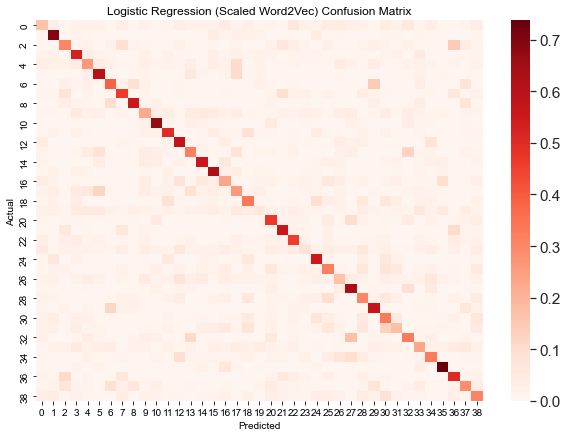

In [22]:
output_metrics(y_word2vec_test, lr_word2vec_predicted, normalize_cm=True, title_cm='Logistic Regression (Scaled Word2Vec) Confusion Matrix')